In [1]:
import torch.optim as optim
from Datasets_Train import train_dataloader
from model_seizure import EEG_CNN
import torch
import torch.nn as nn
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt

In [2]:
def train_model_with_plots(model, dataloader, criterion, optimizer, device, num_epochs=10):
    model.to(device)
    model.train()
    
    # 初始化记录列表
    train_losses = []
    train_accuracies = []
    learning_rates = []
    
    # 学习率调度器
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)
    
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0
        batch_count = 0  # 新增：记录当前batch的序号
        
        progress_bar = tqdm(dataloader, desc=f'Epoch {epoch + 1}/{num_epochs}')
        
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)
            batch_count += 1  # 每次迭代增加batch计数
            
            # 使用batch_count代替原来的i
            progress_bar.set_postfix({
                'loss': running_loss / batch_count,
                'acc': correct_predictions / total_predictions,
                'lr': optimizer.param_groups[0]['lr']
            })
        
        # 计算epoch指标
        epoch_loss = running_loss / len(dataloader)
        epoch_acc = correct_predictions / total_predictions
        current_lr = optimizer.param_groups[0]['lr']
        
        # 记录指标
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        learning_rates.append(current_lr)
        
        # 调整学习率
        scheduler.step(epoch_acc)
        
        # 保存最佳模型
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            torch.save(model.state_dict(), 'model_seizure_5.pth')
    
    # 训练结束后绘制图表
    plt.figure(figsize=(12, 5))
    
    # 损失曲线
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss', color='r')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    
    # 准确率曲线
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy', color='b')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy Curve')
    plt.legend()
    
    plt.tight_layout()
    # plt.savefig('training_metrics.png')  # 保存图表
    plt.show()
    
    print(f'Training completed. Best accuracy: {best_acc:.4f}')
    return train_losses, train_accuracies


Epoch 3/3: 100%|██████████| 16768/16768 [08:56<00:00, 31.26it/s, loss=0.127, acc=0.954, lr=0.001]


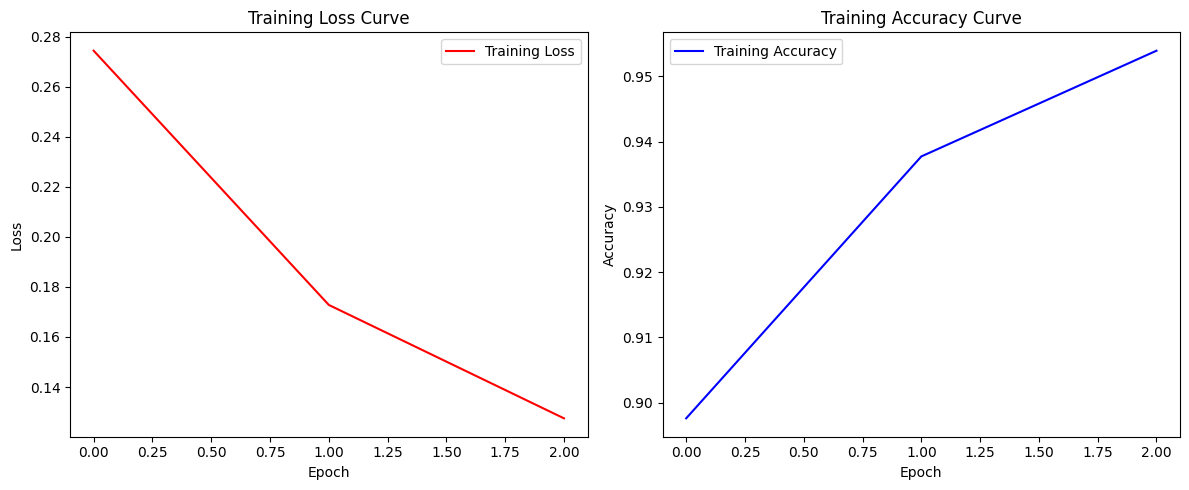

Training completed. Best accuracy: 0.9539


In [3]:

# 初始化模型和优化器
model = EEG_CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 训练并获取指标
losses, accuracies = train_model_with_plots(
    model=model,
    dataloader=train_dataloader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=3
)